# 2D-CNNs for MNIST dataset
* Learn about:
    * [THE MNIST DATABASE](http://yann.lecun.com/exdb/mnist/)
    * Coding with PyTorch Lightning
        * LightningDataModule
        * LightningModule
        * (optional) Logger, Trainer, callbacks
    * Two types of the artificial neuralnetworks
        * Multilayer perceptron (MLP)
        * 2D Convolutional neuralnetworks (2D CNNs)
* Let's try:
    * Build MLP or CNNs by yourself
    * Try to use other loss functions
    * Try to change the training parameters
        * learning rate, batch size, epochs, etc...

## Step1. Lightning data module for MNIST dataset ##

General plan:
1. Separate the image to the tank side and the end caps
2. Rotate image by 90 degrees in $\psi$ ( cylinderical coordinate)
3. Add 2D CNNs for each part of the images at the first layer:
4 rotations x 3 parts = 12 types
4. Analyse the result with test dataset: position dependency in PID, energy, vertex


How to improve CNN:

Try things like shuffling the data, RMSProp (or other associated techniques), Dropout, Supervised layerwise training, Dropout, changing model hyperparameters, or even reducing the model complexity.



https://arxiv.org/pdf/2309.01503

* `train_data`: 50,000
* `test_data`: 10,000
* `val_data`: 10,000

In [1]:
import lightning
print(lightning.__version__)


2.5.1


In [2]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
from typing import Optional



## Ideas to Improve Reconstruction
 shuffling the data, RMSProp (or other associated techniques), Dropout, Supervised layerwise training (shameless plug), Dropout, changing model hyperparameters, or even reducing the model complexity
 

In [3]:
import torch
import matplotlib.pyplot as plt



In [4]:
class HKDataset(LightningDataModule):
    def __init__(
        self,
        batch_size: int = 128,
        num_workers: int = 2,
        ):
        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.mean = ()
        self.std = ()
        self.trans = None

    # MODIFIED
    def setup(self, stage: Optional[str] = None) -> None:
        #imgs = torch.load('../CNNs-HK-2024KCLProject/hyperk_img/rot_imgs_scaled.pt')  
        #labels_targets = torch.load('../CNNs-HK-2024KCLProject/hyperk_img/labels_targets_scaled.pt')
        #indices = torch.load('../CNNs-HK-2024KCLProject/hyperk_img/indices.pt')

        imgs = torch.load('/home/mlproject2024/ml_project/data/hyperk_img_128x128_medium/imgs_scaled.pt')
        labels_targets = torch.load('/home/mlproject2024/ml_project/data/hyperk_img_128x128_medium/labels_targets_scaled.pt')
        indices = torch.load('/home/mlproject2024/ml_project/data/hyperk_img_128x128_medium/indices.pt')

        assert all(k in indices for k in ['train', 'valid', 'test']), "Missing keys in indices.pt"
        self.train_data = torch.utils.data.TensorDataset(imgs[indices['train']], labels_targets[indices['train']])
        self.valid_data = torch.utils.data.TensorDataset(imgs[indices['valid']], labels_targets[indices['valid']])
        self.test_data = torch.utils.data.TensorDataset(imgs[indices['test']], labels_targets[indices['test']])

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, num_workers=self.num_workers)
    

## Step2-2. 2D-CNNs model ##

In [5]:
import torch
from torch import nn
import torch.nn.functional as F  # Importing functional module

class CNNs2D(nn.Module):   
    ...
    def __init__(self):
        super(CNNs2D, self).__init__()

        #self.stn = SpatialTransform(input_size=(128, 128), num_channels=2)


        self.upconv1 = nn.ConvTranspose2d(in_channels=2, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)  # 1x1 --> 2x2
    
        self.conv1 = nn.Sequential(     # Change in_channels = 16 --> in_channels = 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1,bias=False),  # 64x64 --> 32x32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),    # 32x32 --> 16x16
            nn.Dropout(0.2),
        )

        self.upconv2 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1,output_padding=1, bias=False) # 2x2 --> 4x4
        
        self.conv2 = nn.Sequential(   
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),  # 16x16 --> 8x8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),    # 8x8 ---> 4x4
            nn.Dropout(0.2),
        )

        self.upconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1, output_padding=1, bias=False) # 2x2 --> 4x4
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),   # 4x4 --> 2x2
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),   # 2x2 --> 1x1
            nn.Dropout(0.2),
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(32768, 512), # 2class  
            nn.LeakyReLU(inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(inplace=True)
        )

        self.fc_class_layer = nn.Sequential(
            #nn.BatchNorm2d(128),
            nn.Linear(128,64), # 2class
            nn.ReLU(inplace=True),
            nn.Linear(64,2),
            #nn.Sigmoid()
            nn.Softmax(dim=1)      ### Replace?
        )

        self.fc_regression_layer = nn.Sequential(
            #nn.BatchNorm2d(128),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 4), # 4 regression targets
            nn.Tanh()
        )

        # Global Feature Pooling for FC Layers
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # (batch_size, 128, 1, 1)

    def forward(self, x):
        #print('x0', x.shape)
        #x = self.stn(x)  # Special Transform
        ## Swapped the order of conv and upconv layers
        x = self.upconv1(x)  # 64x64 --> 128x128
        x = self.conv1(x)    
        #x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.conv2(x)
        #x = self.upconv2(x)
        x = self.upconv3(x)
        x = self.conv3(x)
        #x = self.upconv3(x)
        

        #x = self.global_pool(x)
        
        x = x.view(x.size(0), -1)
        

        x = self.fc_layer(x)
        
        
        return [self.fc_class_layer(x), self.fc_regression_layer(x)]
    
class SpatialTransform(nn.Module):
       
    def __init__(self, input_size, num_channels):
        super(SpatialTransform, self).__init__()
        
        self.localization = nn.Sequential(
            nn.Conv2d(num_channels, 8, kernel_size=7),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(1440, 32),
            nn.ReLU(),
            nn.Linear(32, 6)
        )

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def forward(self, x):

        batch_size = x.size(0)
        xs = self.localization(x)
        xs = xs.view(batch_size, -1)
        theta = self.fc_loc(xs)
        #theta = theta.view(batch_size, 2, 3)
        theta = theta.view(-1, 2, 3)


        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x = F.grid_sample(x, grid, align_corners=False)
        return x

In [6]:
import torch

model = CNNs2D()
test_input = torch.randn(1, 2, 128, 128)  # (batch_size=1, channels=2, height=64, width=64)
output = model(test_input)


In [7]:
#loss_energy = F.smooth_l1_loss(x_reg[:,0], y_reg[:,0])   # try
#loss = loss_class + (epoch / total_epochs) * (loss_energy + loss_position)  # try


## Step3. Pytorch lightning module ##

In [8]:
from torch.nn import functional as F
from torch import optim
from torch import Tensor
from torchmetrics.classification import BinaryAccuracy
from pytorch_lightning import LightningModule

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))
    
def rse_loss(pred, target):
    return torch.sqrt(torch.sum((pred - target) ** 2) / torch.sum((target - torch.mean(target)) ** 2))

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=1.8):
        super(FocalLoss,self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss(reduction = 'none')
    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        p_t = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-p_t)**self.gamma*ce_loss
        return focal_loss.mean()

class PLModuleMNIST(LightningModule):
    def __init__(self, model, lr_rate):
        super(PLModuleMNIST, self).__init__()
        # New
        
        self.focal_loss = FocalLoss()
        
        # Old
        self.model = model
        self.lr_rate = lr_rate
        self.accuracy_calc = BinaryAccuracy(threshold=0.5)
        
        self.automatic_optimization = False
        self.loss_training = []
        self.loss_valid = []
        self.loss_training_epoch = []
        self.loss_valid_epoch = []
        
        self.acc_training = []
        self.acc_valid = []
        self.acc_training_epoch = []
        self.acc_valid_epoch = []
        # NeW addition
        self.RMSLELoss = RMSLELoss()

    def forward(self, batch: Tensor, **kwargs) -> Tensor:
        #print('batch:', batch.size)
        return self.model(batch)

    #def loss_fn(self, x, y):
    #    #print('loss:x,y',x.shape, y.shape)
    #    #print('type',x[0].dtype, y[0].dtype)
    #    return F.nll_loss(x, y)
    
    #def loss_fn_regression(self, x, y):
    #    #print(x[0][0], y[0][0])
    #    loss_energy = F.l1_loss(x[:,0], y[:,0])
    #    loss_position = F.l1_loss(x[:,1:4], y[:,1:4])
    #    loss = loss_energy + loss_position
    #    return loss
    def epoch_addone(self, epoch):
        return epoch + 1
    
    def loss_fn(self, x, y):
        x_class=x[0]
        y_class=torch.tensor(y[:,0], dtype=torch.int64)
        x_reg=x[1]
        y_reg=y[:,1:]
        

        loss_class = self.focal_loss(x_class, y_class)  ## CHANGE? 
        #loss_class = F.cross_entropy(x_class, y_class)
        #loss_class = F.nll_loss(x_class, y_class)  

        #loss_energy = rse_loss(x_reg[:,1:4], y_reg[:,1:4])
        #loss_energy =  self.RMSLELoss(x_reg[:,0], y_reg[:,0])
        
        #loss_energy =  F.mse_loss(x_reg[:,0], y_reg[:,0])    ## Check if better than RMSLELoss(x_reg[:,0], y_reg[:,0])
        loss_energy = F.l1_loss(x_reg[:,0], y_reg[:,0])   ## Best for loss_energy
        #loss_energy = F.smooth_l1_loss(x_reg[:,0], y_reg[:,0])


        loss_position = rse_loss(x_reg[:,1:4], y_reg[:,1:4])   ### Improves Postiion but is really bad at energy
        #loss_position = self.RMSLELoss(x_reg[:,1:4], y_reg[:,1:4])
        #loss_position = F.mse_loss(x_reg[:,1:4], y_reg[:,1:4])
        #loss_position = F.l1_loss(x_reg[:,1:4], y_reg[:,1:4])
        #self.epochs = self.epoch_addone(self.epochs)
        #print(self.epochs)

        #self.max_epochs = 50*self.max_epochs + self.epochs

        #weight1 = self.epochs / self.max_epochs
        #print(weight1)

        loss = loss_class + loss_energy + loss_position
        return loss

    def training_step(self, batch):
        opt = self.optimizers()
        opt.zero_grad()
        
        x, y = batch
        label=torch.tensor(y[:,0], dtype=torch.int64)
        #targets=y[:,1:5]
        
        logits = self.forward(x)
        loss = self.loss_fn(logits,y)
        #loss = self.loss_fn(logits,y[:,0])
        #loss = self.loss_fn_regression(logits,targets)
        
        acc = self.accuracy_calc(logits[0][:,1], label)
        
        self.manual_backward(loss)
        opt.step()

        self.loss_training.append(loss)
        self.acc_training.append(acc)        

        
    def validation_step(self, batch):
        x, y = batch
        
        label = y[:, 0].clone().detach().to(torch.int64)
        #targets=y[:,1:5]
        #print('val:x,y', x.shape, y.shape)
        #print('type',type(x), type(y))
        logits = self.forward(x)
        loss = self.loss_fn(logits,y)
        acc = self.accuracy_calc(logits[0][:,1], label)
        #loss = self.loss_fn(logits,y[:,0])
        #loss = self.loss_fn_regression(logits,targets)
        #acc = self.accuracy_calc(logits, y[:,0])
        self.loss_valid.append(loss)
        self.acc_valid.append(acc)

    
    def test_step(self, batch):
        x, y = batch
        label=torch.tensor(y[:,0], dtype=torch.int64)
        #targets=y[:,1:5]
        logits = self.forward(x)
        loss = self.loss_fn(logits,y)
        acc = self.accuracy_calc(x[1], label)
        
        #loss = self.loss_fn(logits,y[:,0])
        #loss = self.loss_fn_regression(logits,targets)
        #acc = self.accuracy_calc(logits, y[:,0])

    
    def on_train_epoch_end(self) -> None:
        avg_loss = torch.stack(self.loss_training).mean()
        avg_acc = torch.stack(self.acc_training).mean()
        self.loss_training.clear()
        self.acc_training.clear()
        #print('train_loss:', avg_loss, 'train_acc', avg_acc)
        self.loss_training_epoch.append(avg_loss)
        self.acc_training_epoch.append(avg_acc)
        self.log('loss/train',avg_loss)
        self.log('acc/train',avg_acc)

    def on_validation_epoch_end(self) -> None:
        avg_loss = torch.stack(self.loss_valid).mean()
        avg_acc = torch.stack(self.acc_valid).mean()
        self.loss_valid.clear()
        self.acc_valid.clear()
        self.loss_valid_epoch.append(avg_loss)
        self.acc_valid_epoch.append(avg_acc)
        self.log('loss/valid',avg_loss)
        self.log('acc/valid',avg_acc)


    def configure_optimizers(self):
        #optimizer =  optim.SGD(self.parameters(), lr=self.lr_rate)
        optimizer =  optim.Adam(self.parameters(), lr=self.lr_rate, weight_decay= 1e-5)  # SGD might be better ## It's not 
        lr_scheduler = {'scheduler': optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9), 'name': 'exp_LR'}
        return [optimizer], [lr_scheduler]
        #return optim.Adam(self.model.parameters(), lr=0.001)

In [9]:
#batch = 128
#x, y = batch
# Convert to Cylinderical coordinates
        
#l = torch.sqrt(x**2+y**2)
#phi = torch.arctan(x/y)
        
#x = l * torch.cos(phi)
#y = l * torch.sin(phi)

## Step4. Logger ##
Tensorboard logger is used. A window of tensorboard opens here.

In [10]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger(save_dir='./tb_logs/', name = 'HK')


#%reload_ext tensorboard
#%tensorboard --logdir=./tb_logs/

## Step5. Build & fit a model ##
Select whether to use `MLP()` or `CNNs2D()` for the model. The settings for the learning is described here.
* `lr_rate`: learning rate
* `batch_size`
* `max_epochs`

In [11]:

model_core = CNNs2D() # or MLP()
#model_core = MLP()
model = PLModuleMNIST(model = model_core, lr_rate=0.001)
dm = HKDataset(batch_size=128)

In [12]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar

runner = Trainer(max_epochs=100, 
                 #gpus=[0],
                 accelerator='gpu',  # or 'gpu', 'auto'
                 logger=logger, 
                 callbacks=[TQDMProgressBar(refresh_rate=10)])


runner.fit(model, dm)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type           | Params | Mode 
---------------------------------------------------------
0 | focal_loss    | FocalLoss      | 0      | train
1 | model         | CNNs2D         | 17.2 M | train
2 | accuracy_calc | BinaryAccuracy | 0      | train
3 | RMSLELoss     | RMSLELoss      | 0      | train
---------------------------------------------------------
17.2 M    Trainable params
0         Non-trainable params
17.2 M    Total params
68.811    Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_978471/1468383855.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_class=torch.tensor(y[:,0], dtype=torch.int64)


Epoch 0:   0%|          | 0/625 [00:00<?, ?it/s]                           

/tmp/ipykernel_978471/1468383855.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label=torch.tensor(y[:,0], dtype=torch.int64)


Epoch 99: 100%|██████████| 625/625 [02:11<00:00,  4.77it/s, v_num=187]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 625/625 [02:13<00:00,  4.68it/s, v_num=187]


## Step6. Check the trained model ##
* Structure of the model
* Classification performance for the test dataset
* Feature maps

#### Step6-1. Structure of the trained model ####

In [13]:
## You can load the trained model at the specific checkpoint
#model = PLModuleMNIST.load_from_checkpoint(model=model_core, lr_rate=0.001, checkpoint_path='./tb_logs/MNIST/version_0/checkpoints/epoch=2-step=1173.ckpt')

print(model)

PLModuleMNIST(
  (focal_loss): FocalLoss(
    (ce_loss): CrossEntropyLoss()
  )
  (model): CNNs2D(
    (upconv1): ConvTranspose2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
    (conv1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.2, inplace=False)
    )
    (upconv2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=Tru

In [14]:
model.eval()
#dm.setup() # when you load the model from a checkpoint

labels_targets = []
#outputs = []
outputs_class = []
outputs_targets = []
for batch in dm.test_dataloader():
    x, y = batch 
    
    outputs = model.model(x)
    out_class = outputs[0].to('cpu').detach()
    out_targets =  outputs[1].to('cpu').detach()
    outputs_class.append(out_class)
    outputs_targets.append(out_targets)
    labels_targets.append(y.to('cpu').detach())
    

In [ ]:
labels_targets=np.vstack(labels_targets)
outputs_class=np.vstack(outputs_class)
outputs_targets=np.vstack(outputs_targets)



In [16]:


torch.save(labels_targets, 'l128test_labels_targets_medium.pt')
torch.save(outputs_class, 'l128test_outputs_class_medium.pt')
torch.save(outputs_targets, 'l128test_outputs_targets_medium.pt')

In [18]:
torch.save(labels_targets, 'l128test_labels_targets_medium_DONTDELETE.pt')
torch.save(outputs_class, 'l128test_outputs_class_medium_DONTDELETE.pt')
torch.save(outputs_targets, 'l128test_outputs_targets_medium_DONTDELETE.pt')

#### Step6-2. Classification perfromance for the test dataset ####
`Loss` and `Accuracy` are useful metrics for understanding the performance

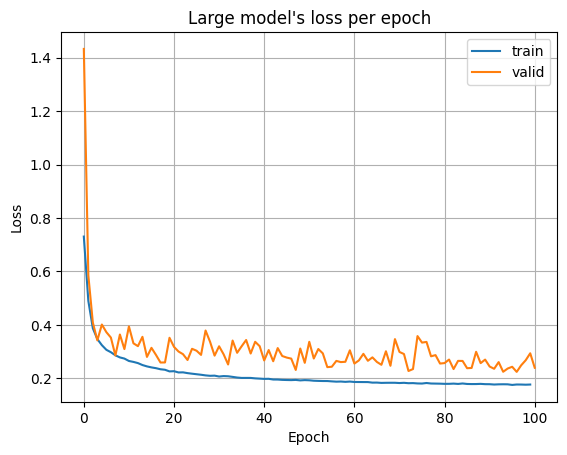

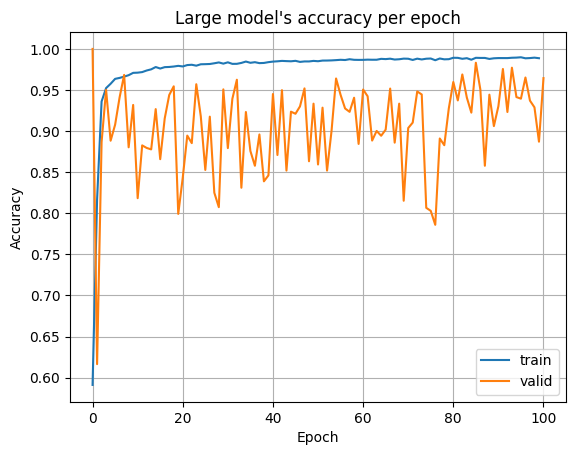

In [17]:
import matplotlib.pyplot as plt
loss_train = [i.to('cpu').detach().numpy() for i in model.loss_training_epoch]
loss_valid = [i.to('cpu').detach().numpy() for i in model.loss_valid_epoch]

plt.plot(loss_train, label='train')
plt.plot(loss_valid, label='valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Large model's loss per epoch")
plt.grid()
plt.legend()
#plt.ylim([None, 1])
plt.show()


acc_train = [i.to('cpu').detach().numpy() for i in model.acc_training_epoch]
acc_valid = [i.to('cpu').detach().numpy() for i in model.acc_valid_epoch]

plt.plot(acc_train, label='train')
plt.plot(acc_valid, label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Large model's accuracy per epoch")
plt.grid()
plt.legend()
#plt.ylim([None, 1])
plt.show()